In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Inconsolata'

# About the dataset

The dataset contains information about various symptoms and their association with 11 Vector-Borne Diseases. Each sample includes the presence or absence of different symptoms, as well as the corresponding prognosis. The 11 diseases present in the dataset are:

* Chikungunya
* Dengue
* Zika
* Yellow Fever
* Raft Valley Fever
* West Nile Fever
* Malaria
* Tungiasis
* Japanese Encephalitis
*  Plague
* Lyme Disease

Please note that in the notebook, I will refer to the samples or entries as patients. Additionally, I will use the terms "prognosis" and "diagnosis" interchangeably, although they do not have exactly the same meaning.

It's important to keep in mind that this analysis of the dataset is not a thorough examination, but rather a brief exploration of its features. That means not all the methods that could be used in a more complete EDA will be used here.

In [3]:
data = pd.read_csv('/kaggle/input/vector-borne-disease-prediction/trainn.csv')

# Initial Overview

We will start by exploring the basic information of our dataset using the info method that will show us number of entries, number of columns, column names, column types and column non-null values amongst other information.

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sudden_fever           252 non-null    int64 
 1   headache               252 non-null    int64 
 2   mouth_bleed            252 non-null    int64 
 3   nose_bleed             252 non-null    int64 
 4   muscle_pain            252 non-null    int64 
 5   joint_pain             252 non-null    int64 
 6   vomiting               252 non-null    int64 
 7   rash                   252 non-null    int64 
 8   diarrhea               252 non-null    int64 
 9   hypotension            252 non-null    int64 
 10  pleural_effusion       252 non-null    int64 
 11  ascites                252 non-null    int64 
 12  gastro_bleeding        252 non-null    int64 
 13  swelling               252 non-null    int64 
 14  nausea                 252 non-null    int64 
 15  chills                 

There are 252 entries in the dataset, and we can see that there are 64 symptom columns, with the 65th column corresponding to the prognosis.

# Distribution Analysis

Since the target variable of a potential model will be the 'prognosis' column, we will start analyizing its distribution. We will also analyze the distribution of the symptom columns in our dataset.

Chikungunya              23
Dengue                   23
Rift Valley fever        23
Yellow Fever             23
Zika                     23
Malaria                  23
Japanese encephalitis    23
West Nile fever          23
Plague                   23
Tungiasis                23
Lyme disease             22
Name: prognosis, dtype: int64


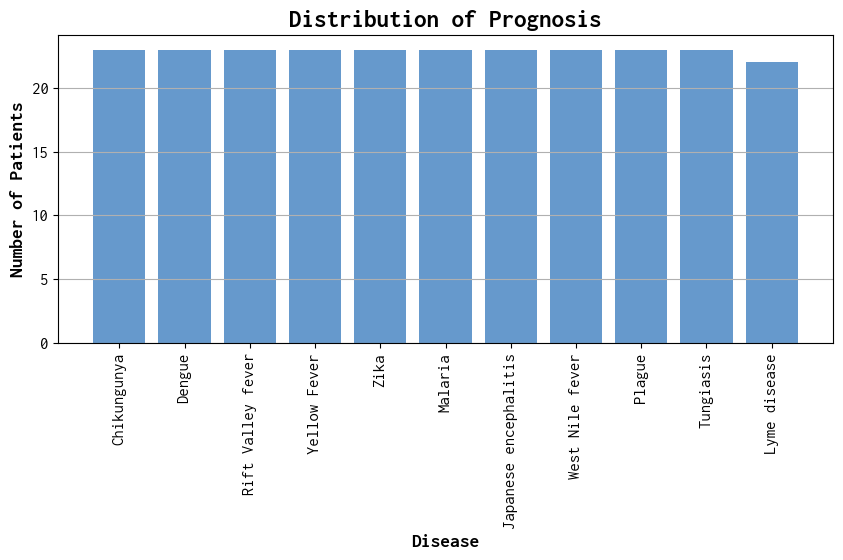

In [5]:
# Count appearances of each disease
target_counts = data['prognosis'].value_counts()

# Visualize the distribution of the diseases in the dataset
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(target_counts.index, target_counts.values, color='#6699cc')

ax.set_title('Distribution of Prognosis', fontsize=18, fontweight='bold')
ax.set_xlabel('Disease', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=14, fontweight='bold')
ax.grid(axis='y')

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

print(target_counts)
plt.show()

We can see that all prognosis values have 23 entries in the dataset with the exception of 'Lyme disease' which has 22 entries. These might be very few entries for training a model, but at least they are almost equally distributed.



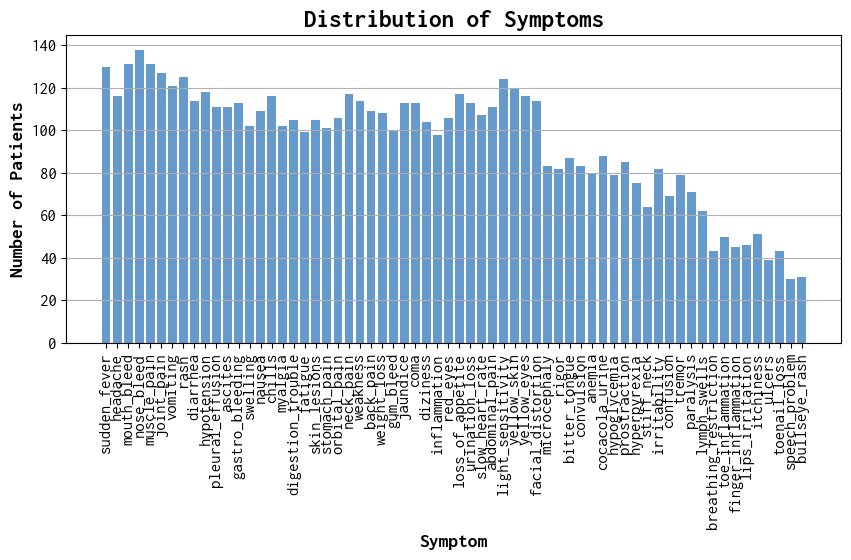

In [6]:
# Count appearances of each symptom
symptom_counts = data.drop('prognosis', axis=1).sum()

# Visualize the distribution of symptoms in the dataset
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(symptom_counts.index, symptom_counts.values, color='#6699cc')

ax.set_title('Distribution of Symptoms', fontsize=18, fontweight='bold')
ax.set_xlabel('Symptom', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=14, fontweight='bold')
ax.grid(axis='y')

plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

The distribution of symptoms in the dataset is not uniform, with some symptoms appearing in over 120 patients, while others appear in less than 40 patients. Although this information alone may not be very informative, it is a useful initial overview.

In the next step, we will analyze the frequency of each symptom of the data for each prognosis. This will give us some insights about which symptoms are associated with which diseases.

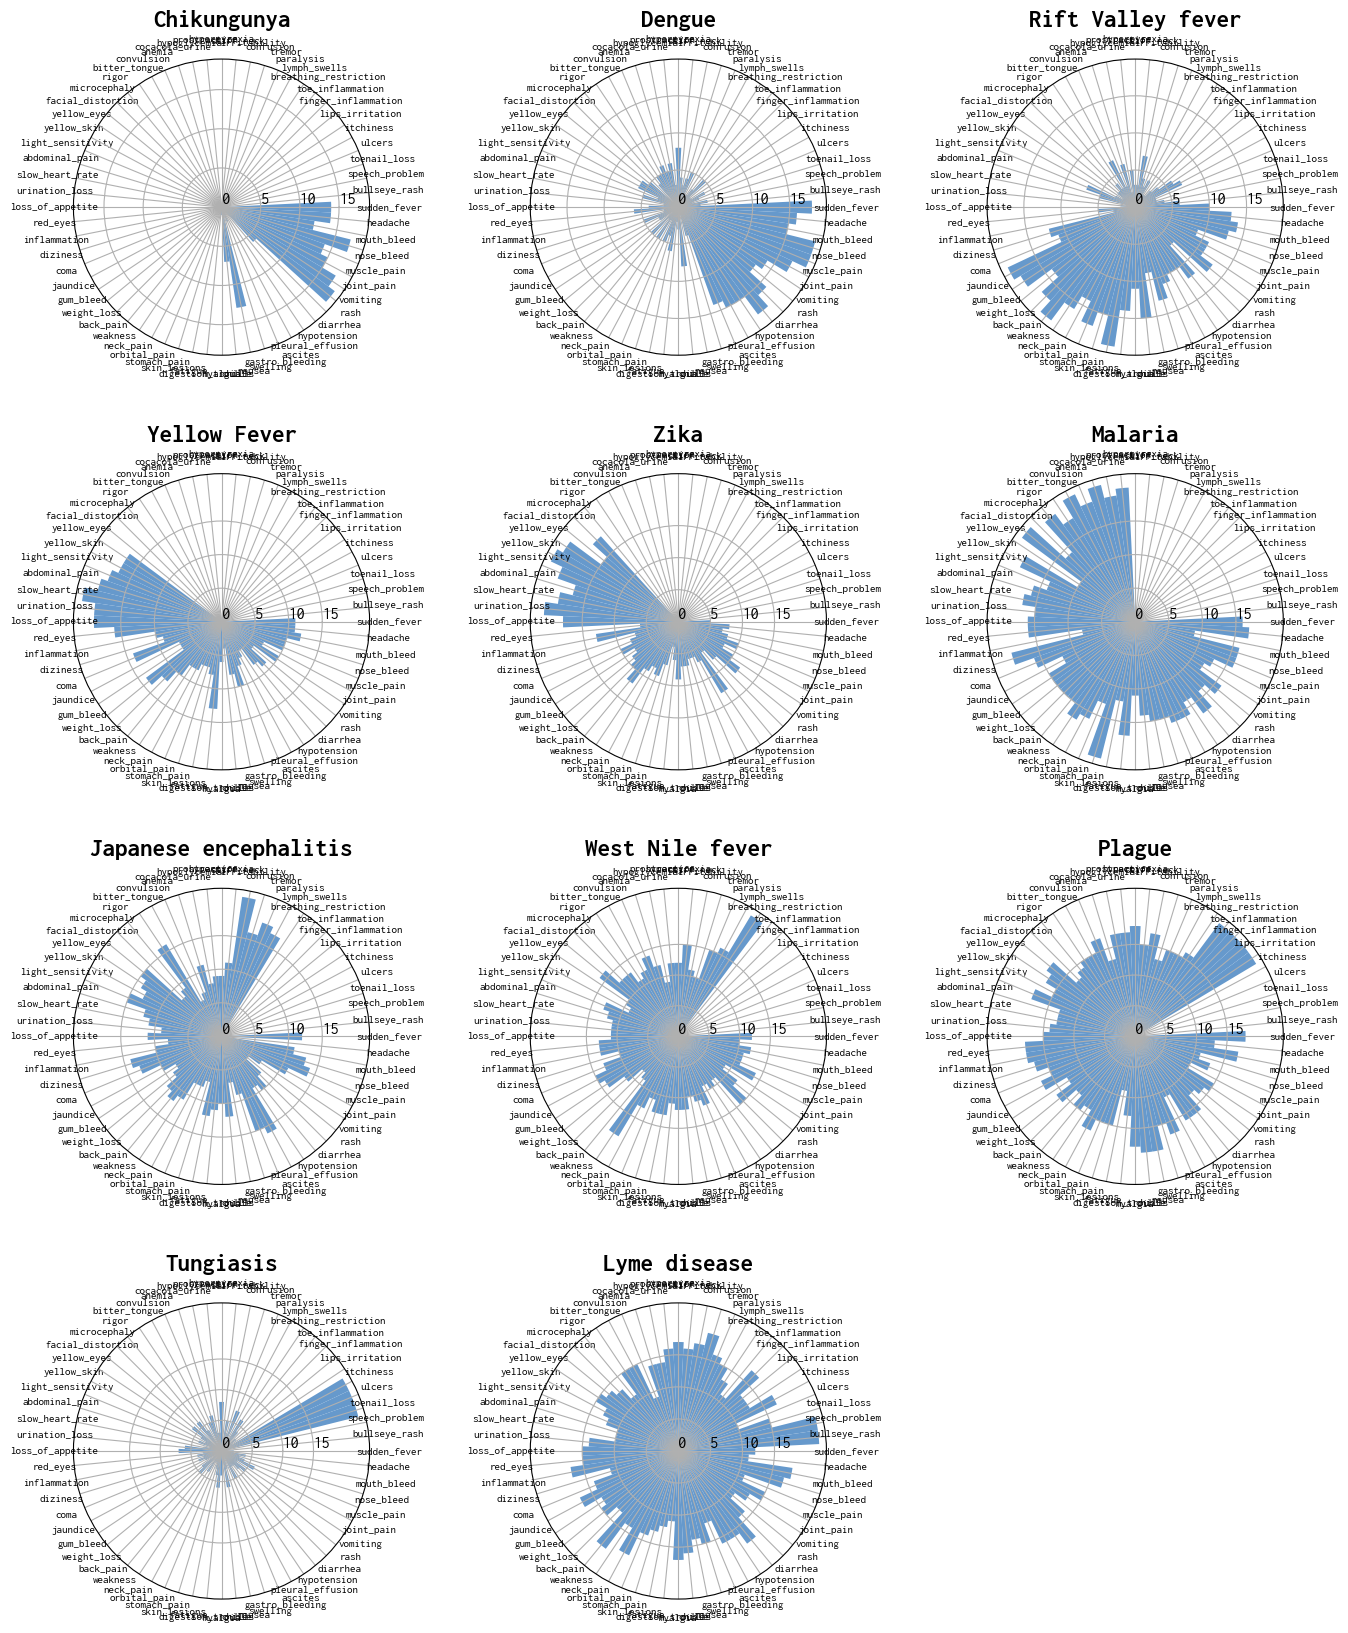

In [7]:
symptoms_columns = data.columns[:-1]
diseases = data['prognosis'].unique()

# Subplot grid shape
nrows = 4
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20), subplot_kw=dict(polar=True))
axs = axs.flatten()

# Loop over each disease and create a circular chart
for i, disease in enumerate(diseases):

    disease_data = data[data['prognosis'] == disease]
    symptom_counts = disease_data[symptoms_columns].sum().astype(int)

    # Angle for each symptom
    angles = np.linspace(0, 2*np.pi, len(symptom_counts.index), endpoint=False).astype('float')

    # Create the plot
    ax = axs[i]
    ax.bar(angles, symptom_counts.values, width=angles[1]-angles[0], color='#6699cc')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    label_pos = np.linspace(0, 2*np.pi, len(symptom_counts.index), endpoint=False)
    ax.set_xticks(angles)
    ax.set_xticklabels(symptom_counts.index, fontsize=8)
    ax.set_yticks([0, 5, 10, 15])
    ax.set_yticklabels(['0', '5', '10', '15'], fontsize=12)
    ax.set_title(disease, fontsize=18, fontweight='bold')
    ax.grid(True)


# Hide the last subplot
if len(diseases) < nrows*ncols:
    for i in range(len(diseases), nrows*ncols):
        fig.delaxes(axs[i])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

An interesting observation is how some diseases, such as 'Chikungunya' and 'Tungiasis', have only a few symptoms that appear with very high frequency, while the rest of the symptoms have close to zero frequency. On the other hand, we have diseases like 'Lyme disease' in which most symptoms appear with a moderate-high frequency.

Another interesting observation is how some symptoms appear to be specific to a disease (or a subset of diseases), while others seem to be more general. In one extreme, we have the 'speech_problem' symptom, which appears with a relatively high frequency only in patients of Lyme Disease. On the other hand, we have the 'joint_pain' symptom, which appears with a certain frequency in almost all disease categories. This observation leads to a question: which symptoms are the most indicative when it comes to differentiate diseases based on the information we have? In previous observations, it is clear that 'speech_problem' is more indicative than 'joint_pain'. Of course, this is a very simplistic approach since we are not taking into account more complex relationships, such as the relationship between groups of symptoms and diseases. However, it is a good first step towards feature selection. We will analyze this further in the notebook.

To view the results visually, you can uncomment the code in the next cell.



In [8]:
'''chikungunya = data[data['prognosis'] == 'Chikungunya'][data.columns[:-1]].sum()
print(chikungunya[chikungunya > 5])'''

'''lyme = data[data['prognosis'] == 'Lyme disease'][data.columns[:-1]].sum()
print(lyme[lyme > 5])'''

'''print(data[data['speech_problem'] == 1]['prognosis'].value_counts())'''

'''print(data[data['joint_pain'] == 1]['prognosis'].value_counts())'''

"print(data[data['joint_pain'] == 1]['prognosis'].value_counts())"

We have analyzed the frecuency to which each symptom appear for each disease but more than that we can analyze the frequency of symptom combinations in dataset in general and for each 

In [9]:
import warnings
warnings.filterwarnings('ignore')
length = 3
for disease in diseases:
    frequent_itemsets = apriori(data[data['prognosis'] == disease][symptoms_columns],  min_support=0.3, max_len=5, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    filtered_itemsets = frequent_itemsets[(frequent_itemsets['length'] == length)]
    if not filtered_itemsets.empty:
        print(f'Most frequent {length}-symptom combinations for {disease}:')
        print(filtered_itemsets.sort_values(by=['support'], ascending=False)[['support', 'itemsets']].head(3))
        print('\n')

Most frequent 3-symptom combinations for Chikungunya:
     support                             itemsets
61  0.434783  (muscle_pain, headache, nose_bleed)
64  0.391304         (headache, rash, nose_bleed)
76  0.391304         (vomiting, rash, nose_bleed)


Most frequent 3-symptom combinations for Dengue:
      support                                  itemsets
131  0.608696  (sudden_fever, hypotension, muscle_pain)
176  0.565217  (headache, pleural_effusion, nose_bleed)
171  0.565217        (headache, joint_pain, nose_bleed)


Most frequent 3-symptom combinations for Rift Valley fever:
      support                        itemsets
857  0.652174   (weakness, fatigue, jaundice)
856  0.608696  (weakness, fatigue, gum_bleed)
865  0.608696  (fatigue, jaundice, gum_bleed)


Most frequent 3-symptom combinations for Yellow Fever:
      support                                           itemsets
571  0.695652  (slow_heart_rate, loss_of_appetite, abdominal_...
573  0.652174   (slow_heart_rate, loss


# Feature Analysis

## Adding a feature

Before diving into the feature analysis, we can extract more information from the dataset by adding new features based on the existing ones. Adding new features can be a useful practice in EDA. In this particular dataset, we can count the number of symptoms each patient has as a new feature. This feature might help us identify a disease based on a patient's symptom count since some diseases might present many symptoms, while others might have more specific symptoms.

In [10]:
data['symptom_count'] = data.iloc[:, :-1].sum(axis=1)

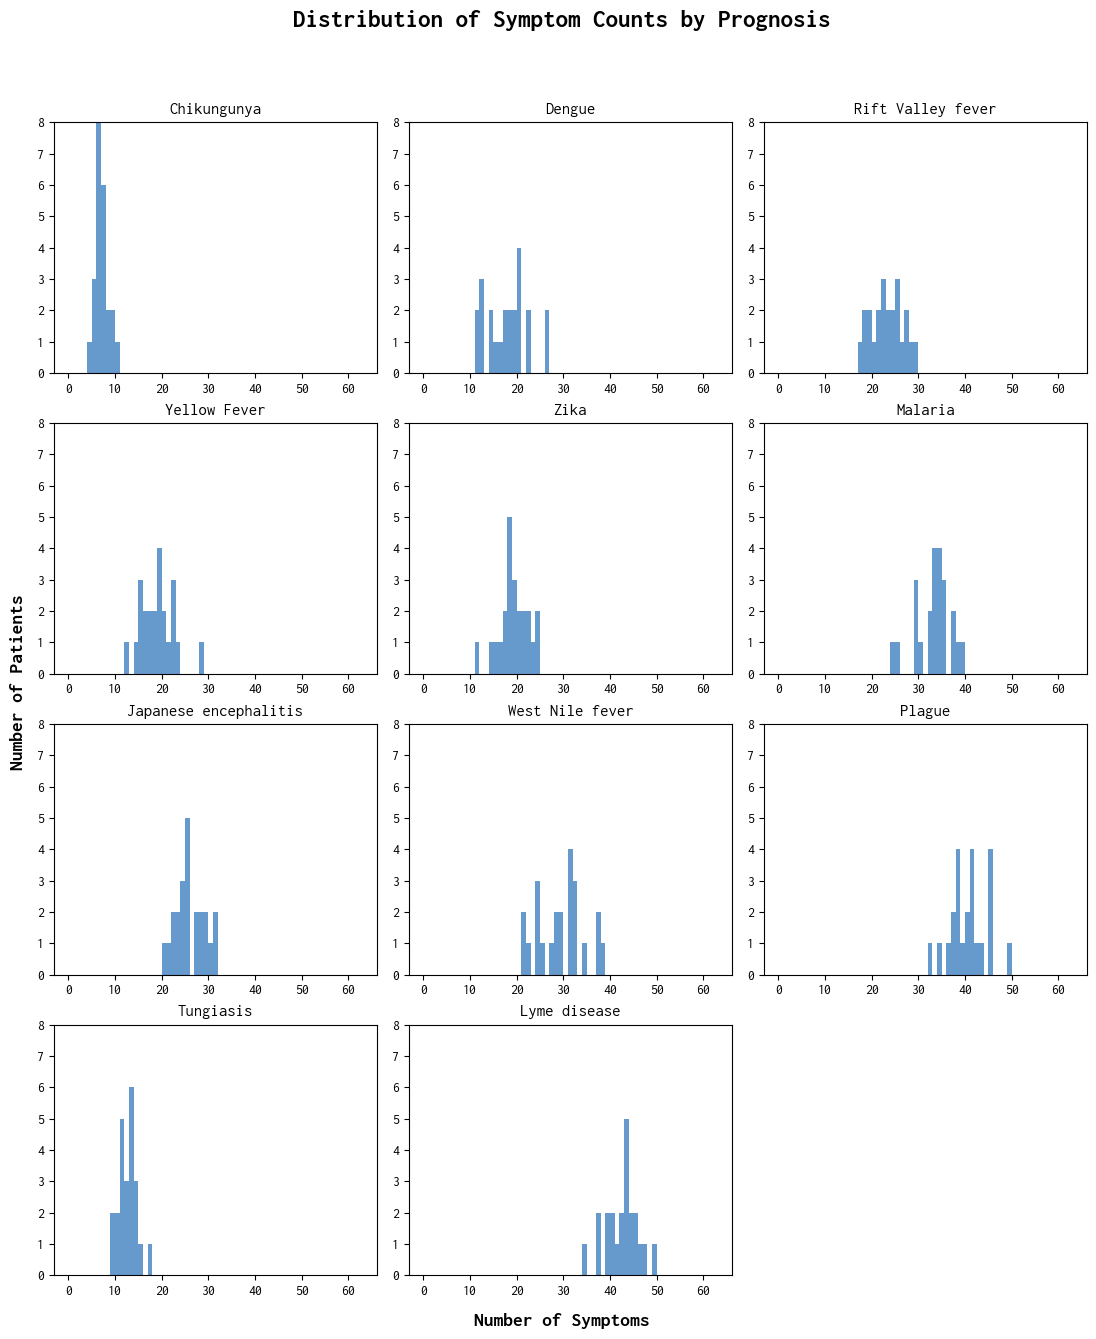

In [11]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
axs = axs.flatten()

# Iterate over each prognosis and create a histogram in the corresponding plot
for i, prognosis in enumerate(diseases):
    ax = axs[i]
    row = i // 3
    col = i % 3
    data_prognosis = data[data['prognosis'] == prognosis]
    ax.hist(data_prognosis['symptom_count'], bins = range(0,64), color='#6699cc')
    ax.set_title(prognosis)
    ax.set_ylim([0,8])

# Hide the last subplot
if len(diseases) < nrows*ncols:
    for i in range(len(diseases), nrows*ncols):
        fig.delaxes(axs[i])
    
fig.suptitle('Distribution of Symptom Counts by Prognosis', fontsize=18, fontweight='bold')
fig.text(0.5, 0.04, 'Number of Symptoms', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Number of Patients', va='center', rotation='vertical', fontsize=14, fontweight='bold')
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
fig.subplots_adjust(hspace=0.2)

plt.show()


It seems our assumption was correct. Patients with diseases like 'Plague' or 'Lyme disease' have over 30 symptoms present, while those with 'Chikungunya' have less than 10 symptoms. This information could be useful for training the model.

## Feature correlation

A useful and common practice when conducting an EDA is to plot a correlation matrix, as it can help to understand the relationships between features themselves and between features and the target variable (although, since the target variable is categorical, we will study the latter in the next section). This can help us make decisions such as feature selection or further feature engineering.

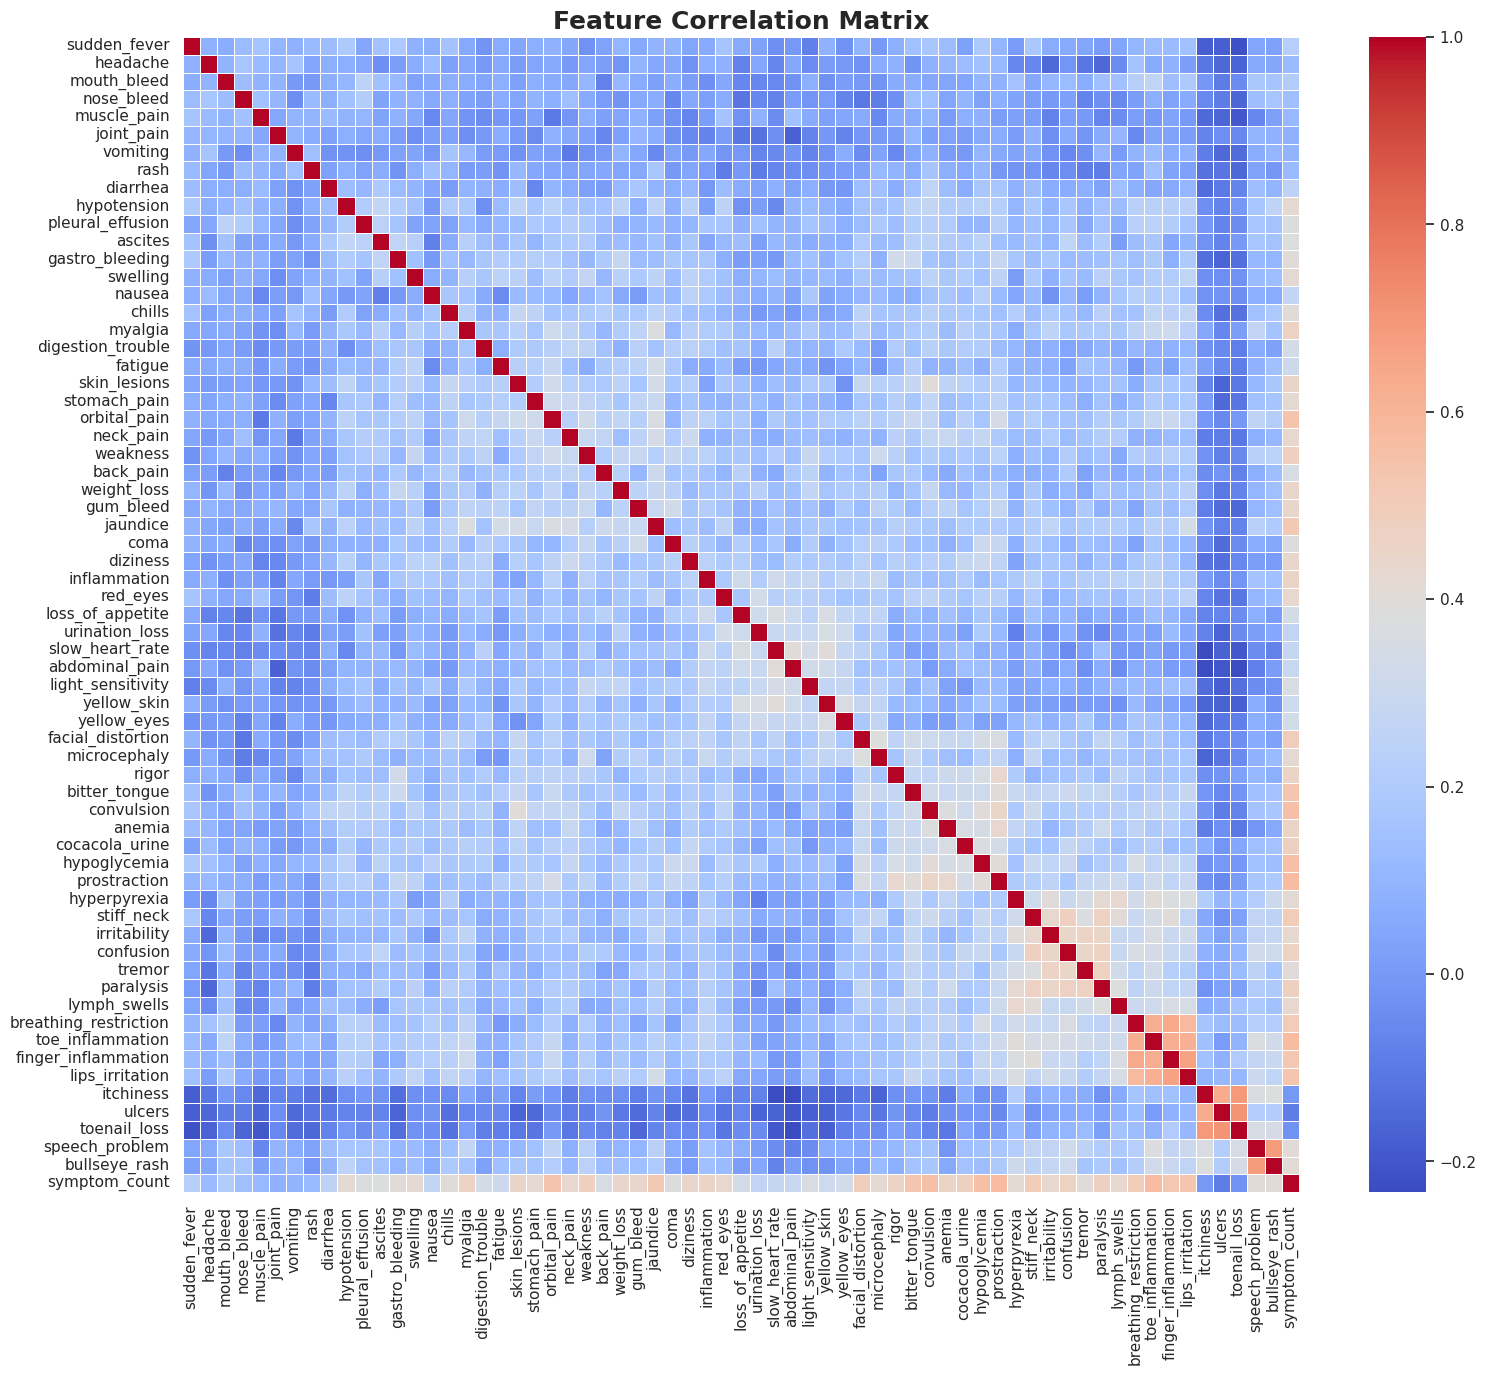

In [12]:
corr = data.drop('prognosis', axis=1).corr()

# Create a heatmap of the correlation matrix
sns.set(style="white")
fig, ax = plt.subplots(figsize=(18,15)) # increase the size of the plot
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=.5, ax=ax)
plt.title('Feature Correlation Matrix', fontsize=18, fontweight='bold')
plt.show()

The feature correlation matrix shows how strongly each symptom is related to each other symptom in the dataset.

A high positive correlation between two symptoms means that they tend to appear together in the same patient, while a high negative correlation means that they tend to appear in different patients. On the other hand, a low correlation indicates that the presence of one symptom does not necessarily imply the presence of the other.

The correlation matrix reveals that there are no relationships below -0.3, suggesting that there are no significant negative correlations between the symptoms. On the other hand, positive correlations are more common in the dataset, although only a few are highly significant with correlations of more than 0.6 or 0.8. The following symptom groups exhibit a relatively high correlation with each other:
* breathing_restriction, toe_inflamation, finger_inflamation and lips_irritation
* itchiness, ulcers and toenail_loss
* speech_problem, bullseye_rush

The relationship between toe_inflammation and finger_inflammation makes sense even from a non-medical expert point of view. It would be useful to investigate the other relationships to see if they can be associated with each other or appear in patients with the same disease.


## Feature Selection

Now let's return to the question of which symptoms are most useful in differentiating between diseases based on the available information. To answer this question, we will perform the chi-square test of independence, which allows us to test whether there is a significant association between two variables. In our case, we want to test whether there is a significant association between the presence or absence of each symptom and the disease a patient has been diagnosed with.

The chi-square test produces a test statistic and a p-value. The test statistic measures how different the observed frequencies of symptoms are from what we would expect if there was no association between symptoms and diseases. The p-value measures the strength of evidence against the null hypothesis of no association. If the p-value is very low (typically less than 0.05), we can reject the null hypothesis and conclude that there is strong evidence that the symptom is associated with the disease.

The results of this test could be useful for feature selection, as they can help us identify the most relevant features.

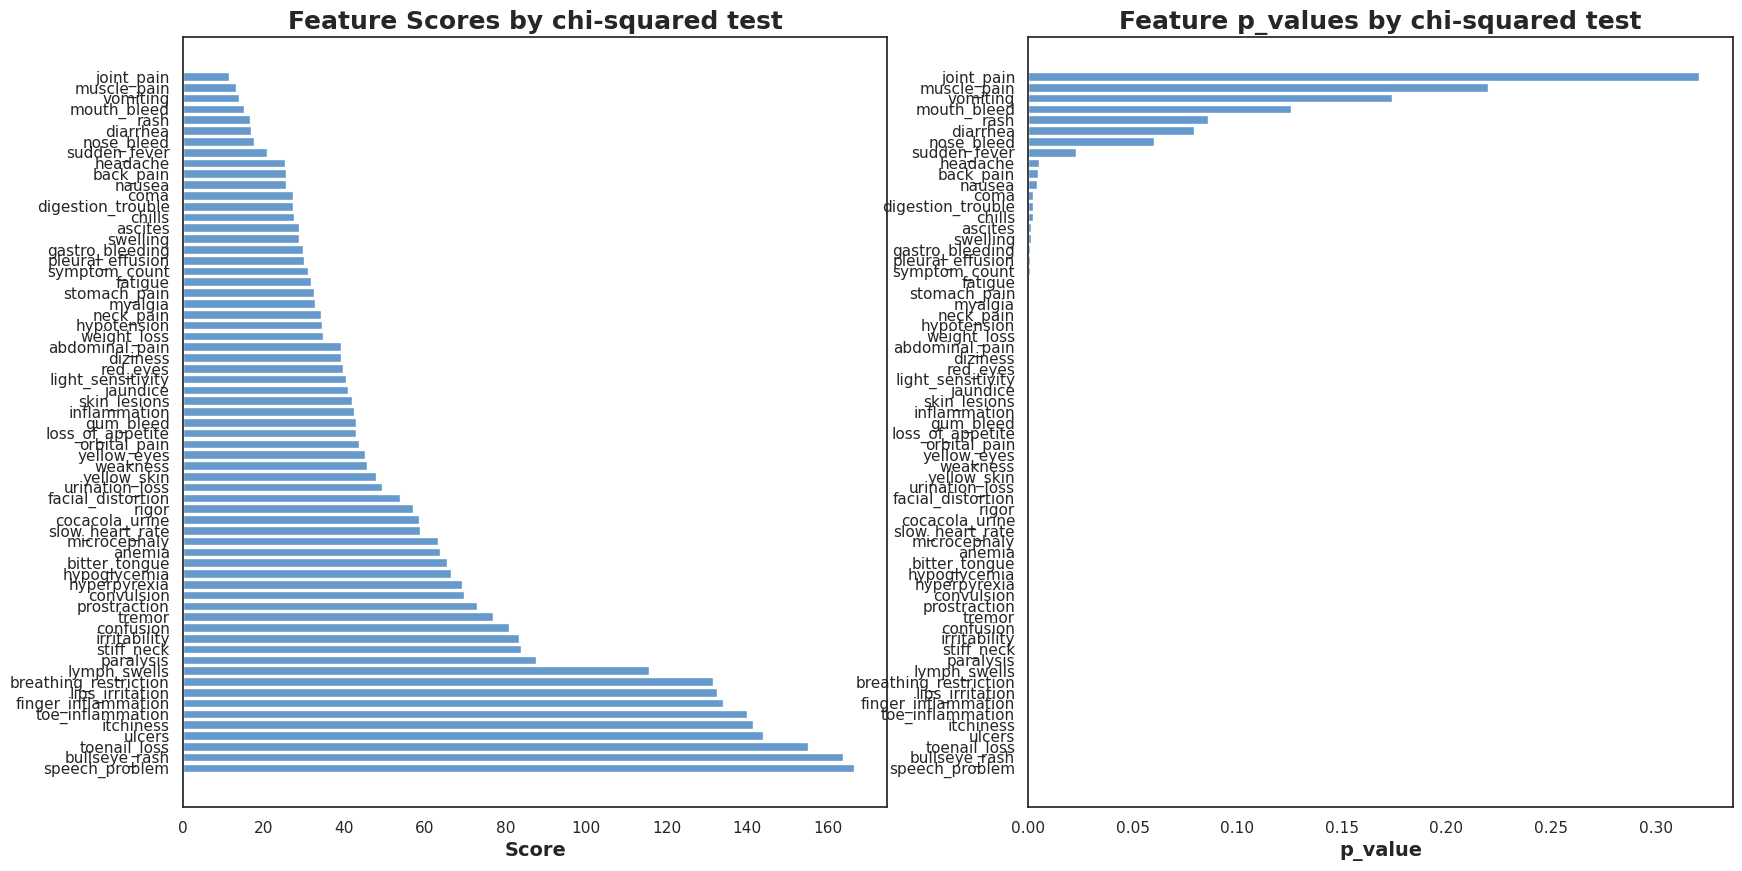

In [13]:
# Scale the data
scaler = MinMaxScaler()
X = data.drop('prognosis', axis=1)
X_scaled = scaler.fit_transform(X)

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(data['prognosis'])

# Perform chi-squared test and get scores and p-values
scores, p_values = chi2(X_scaled, y)

feature_scores = {feature: (score, p_val) for feature, score, p_val in zip(X.columns, scores, p_values)}
sorted_scores = sorted(feature_scores.items(), key=lambda x: x[1][0], reverse=True)

# Visualize the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Scores
axs[0].barh(range(len(sorted_scores)), [score[1][0] for score in sorted_scores],  color='#6699cc')
axs[0].set_yticks(range(len(sorted_scores)))
axs[0].set_yticklabels([score[0] for score in sorted_scores])
axs[0].set_xlabel('Score', fontsize=14, fontweight='bold')
axs[0].set_title('Feature Scores by chi-squared test', fontsize=18, fontweight='bold')

# p-values
axs[1].barh(range(len(sorted_scores)), [score[1][1] for score in sorted_scores],  color='#6699cc')
axs[1].set_yticks(range(len(sorted_scores)))
axs[1].set_yticklabels([score[0] for score in sorted_scores])
axs[1].set_xlabel('p_value', fontsize=14, fontweight='bold')
axs[1].set_title('Feature p_values by chi-squared test', fontsize=18, fontweight='bold')

plt.show()

Upon performing the chi2 test, we find that 'joint_pain', 'vomiting', and 'muscle_pain' are among the least useful symptoms for predicting the disease of a patient. Conversely, 'speech_problem', 'toenail_loss', and 'bullseye_rash' are among the most useful. It is worth noting, however, that the usefulness of 'symptom_count' is not as high as we would like it to be, even though it still passes the typical p-value threshold of 0.5.

# Conclusion

In conclusion, I believe that this initial exploratory data analysis provides a decent first approach to understanding the characteristics of this dataset. While there are certainly many more techniques and practices that can be applied when exploring data (such as outlier detection, clustering analysis, and dimensionality reduction), as someone who is still learning and gaining experience in data analysis, I found this process to be a valuable learning experience. I believe that the insights gained from this analysis, including the distribution of symptoms, the chi-squared test results, and the new symptom count feature, can help to inform future modeling and analysis of this dataset.

To see an implementation of a model for predicting prognosis based on symptoms, please refer to my notebook at: https://www.kaggle.com/code/irda22/s3e13-svc.